In [3]:
from sklearn.datasets import fetch_openml

bikes = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas")
# Make an explicit copy to avoid "SettingWithCopyWarning" from pandas
X, y = bikes.data.copy(), bikes.target

In [6]:
X.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0


In [4]:
X["weather"].value_counts()

clear         11413
misty          4544
rain           1419
heavy_rain        3
Name: weather, dtype: int64

In [7]:
X["weather"].replace(to_replace="heavy_rain", value="rain", inplace=True)
X["year"].value_counts()

1    8734
0    8645
Name: year, dtype: int64

In [8]:
mask_training = X["year"] == 0.0
X = X.drop(columns=["year"])
X_train, y_train = X[mask_training], y[mask_training]
X_test, y_test = X[~mask_training], y[~mask_training]

In [9]:
numerical_features = [
    "temp",
    "feel_temp",
    "humidity",
    "windspeed",
]
categorical_features = X_train.columns.drop(numerical_features)

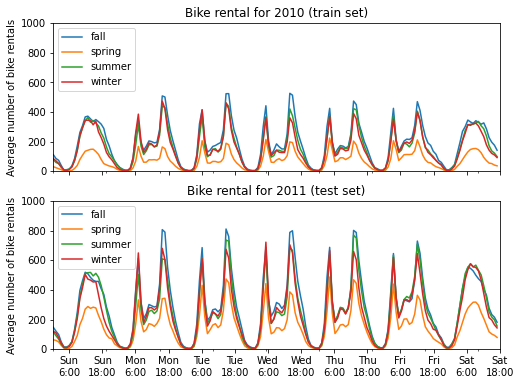

In [10]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

days = ("Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat")
hours = tuple(range(24))
xticklabels = [f"{day}\n{hour}:00" for day, hour in product(days, hours)]
xtick_start, xtick_period = 6, 12

fig, axs = plt.subplots(nrows=2, figsize=(8, 6), sharey=True, sharex=True)
average_bike_rentals = bikes.frame.groupby(["year", "season", "weekday", "hour"]).mean(
    numeric_only=True
)["count"]
for ax, (idx, df) in zip(axs, average_bike_rentals.groupby("year")):
    df.groupby("season").plot(ax=ax, legend=True)

    # decorate the plot
    ax.set_xticks(
        np.linspace(
            start=xtick_start,
            stop=len(xticklabels),
            num=len(xticklabels) // xtick_period,
        )
    )
    ax.set_xticklabels(xticklabels[xtick_start::xtick_period])
    ax.set_xlabel("")
    ax.set_ylabel("Average number of bike rentals")
    ax.set_title(
        f"Bike rental for {'2010 (train set)' if idx == 0.0 else '2011 (test set)'}"
    )
    ax.set_ylim(0, 1_000)
    ax.set_xlim(0, len(xticklabels))
    ax.legend(loc=2)

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder

mlp_preprocessor = ColumnTransformer(
    transformers=[
        ("num", QuantileTransformer(n_quantiles=100), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)
mlp_preprocessor

ColumnTransformer(transformers=[('num', QuantileTransformer(n_quantiles=100),
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object'))])

In [12]:
from sklearn.preprocessing import OrdinalEncoder

hgbdt_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
hgbdt_preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('cat', OrdinalEncoder(),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object')),
                                ('num', 'passthrough',
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed'])],
                  verbose_feature_names_out=False)

## 1-way partial dependence with different models

In [13]:
from time import time
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

print("Training MLPRegressor...")
tic = time()
mlp_model = make_pipeline(
    mlp_preprocessor,
    MLPRegressor(
        hidden_layer_sizes=(30, 15),
        learning_rate_init=0.01,
        early_stopping=True,
        random_state=0,
    ),
)
mlp_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {mlp_model.score(X_test, y_test):.2f}")

Training MLPRegressor...
done in 3.858s
Test R2 score: 0.61


Computing partial dependence plots...
done in 7.973s


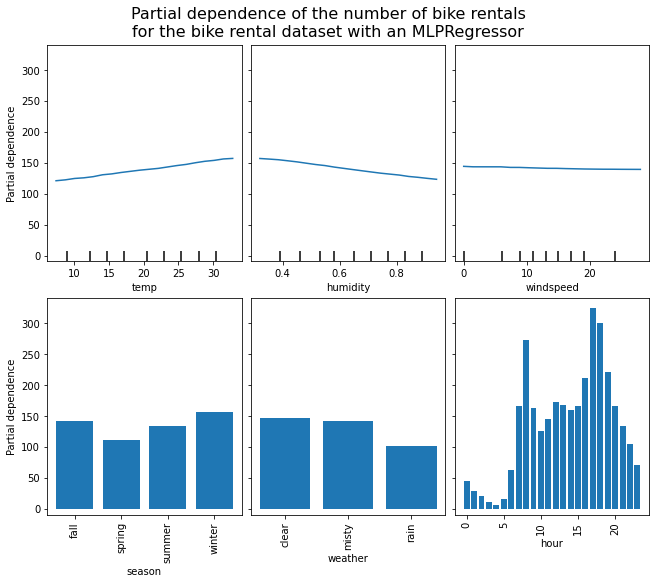

In [14]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": ["temp", "humidity", "windspeed", "season", "weather", "hour"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": categorical_features,
}
tic = time()
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    mlp_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "Partial dependence of the number of bike rentals\n"
    "for the bike rental dataset with an MLPRegressor",
    fontsize=16,
)

## HistGradientBoostingRegressor 

In [16]:
from sklearn.ensemble import HistGradientBoostingRegressor

print("Training HistGradientBoostingRegressor...")
tic = time()
hgbdt_model = make_pipeline(
    hgbdt_preprocessor,
    HistGradientBoostingRegressor(
        categorical_features=categorical_features, random_state=0
    ),
)
hgbdt_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {hgbdt_model.score(X_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
done in 1.970s
Test R2 score: 0.64


Computing partial dependence plots...
done in 9.623s


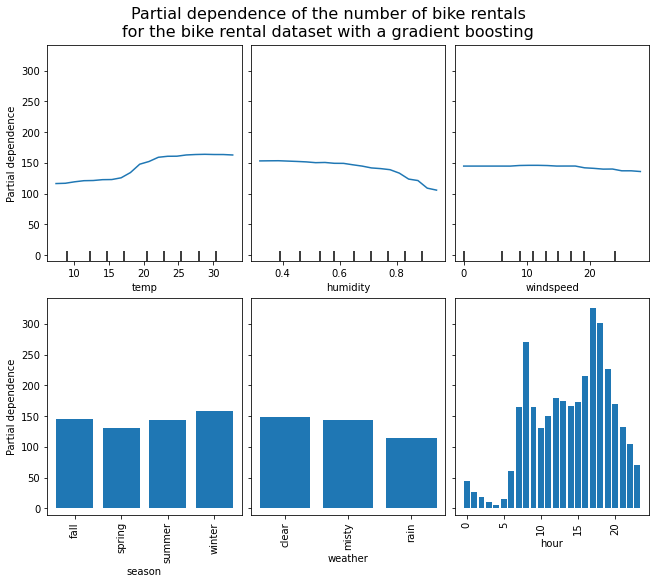

In [17]:
print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "Partial dependence of the number of bike rentals\n"
    "for the bike rental dataset with a gradient boosting",
    fontsize=16,
)